In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    # Check if first class label is numeric or alphabetic
    if class_name == annotation_name:
        ## Convert to int type
        tmp_y_train = train_data[annotation_name].copy()
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_numpy()
    else:
        y_train = train_data[annotation_name].to_numpy()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
#                         callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

def joint_model(is_max, weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                pred_df, y_train_2, pred_df_test, y_test_2,
                class_weight_dict_1, class_weight_dict_2, joint_batch_size, joint_epochs):
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict_1, joint_batch_size, joint_epochs):
        joint_full_model_1 = models_nn.create_joint_model(pred_df_full)
        history_1 = joint_full_model_1.fit(x=pred_df_full, 
                                           y=y_train_1, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_full_test,y_test_1), 
                                           #callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict_1,
                                           verbose=0)
        joint_predict_1 = joint_full_model_1.predict(pred_df_full_test)
        # joint_predict_round = []
        # for a in joint_predict:
        #     joint_predict_round.append(np.argmax(a))
        joint_predict_round_1 = joint_predict_1.round()
        out1 = precision_recall_fscore_support(y_test_1, np.array(joint_predict_round_1), average='macro')

        val_f1_list = history_1.history['val_f1_m']
        
        # if is_max, then take max f1 from history, otherwise take last value
        if is_max == True:
            best_val_f1 = max(val_f1_list)
        else:
            best_val_f1 = val_f1_list[-1]
        
        best_val_prec = history_1.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history_1.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Deception", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    rapport_1, rapport_2 = helper("Rapport", pred_df, y_train_2, pred_df_test, y_test_2, class_weight_dict_2, joint_batch_size, joint_epochs)

    
    return decep_1, decep_2, rapport_1, rapport_2

In [7]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name, is_drop_rapport):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, class_name, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, class_name, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, class_name, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, class_name, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, class_name, 'Answer.1gamemove.yes_label')
        print("#############################################################")
        print("Class weights generated")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        _, _ = individual_model('Deception', X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model('Rapport', X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model('Share Info', X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model('Reasoning', X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model('Gamemove', X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
        
        if is_drop_rapport:
            pred_df_full, pred_test_df_full = pred_df.copy(), pred_test_df.copy()
            
        ## Generate weighted one-hot encodings (HARD-CODED)
        pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)
        pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _, out2_wo_weights, _ = joint_model(False, None, pred_df_full, y_train_deception, pred_test_df_full, y_test_deception,
                                                             pred_df, y_train_rapport, pred_test_df, y_test_rapport,
                                                             deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Throughput
        out1_tp, _, out2_tp, _ = joint_model(False, 'Throughput', pred_df_full_throughput, y_train_deception, pred_df_full_throughput_test, y_test_deception,
                                       pred_df_throughput, y_train_rapport, pred_df_throughput_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Worktime
        out1_wt, _, out2_wt, _ = joint_model(False, 'Worktime', pred_df_full_worktime, y_train_deception, pred_df_full_worktime_test, y_test_deception,
                                       pred_df_worktime, y_train_rapport, pred_df_worktime_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by PC Agreement
        out1_pc, _, out2_pc, _ = joint_model(False, 'PC Agreement', pred_df_full_agreement, y_train_deception, pred_df_full_agreement_test, y_test_deception,
                                       pred_df_agreement, y_train_rapport, pred_df_agreement_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Text Length
        out1_tl, _, out2_tl, _ = joint_model(False, 'Text Length', pred_df_full_textlength, y_train_deception, pred_df_full_textlength_test, y_test_deception,
                                       pred_df_textlength, y_train_rapport, pred_df_textlength_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Special options
        out1_sp, _, out2_sp, _ = joint_model(False, 'Special', pred_df_full_special, y_train_deception, pred_df_full_special_test, y_test_deception,
                                       pred_df_special, y_train_rapport, pred_df_special_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out2_wo_weights, out1_tp, out2_tp, out1_wt, out2_wt, 
                                                   out1_pc, out2_pc, out1_tl, out2_tl, out1_sp, out2_sp]
    print("Done")
    return results

In [8]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL2'
special_option = 'SP3'
k_option_for_tp = 3
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'lstm-attn'
indiv_batch_size = 128
indiv_epochs = 50

# Joint model options
joint_batch_size = 64
joint_epochs = 32

Full dataset proportions w.r.t. Input.deception_quadrant
Straightforward    10808
Cassandra            558
Name: Input.deception_quadrant, dtype: int64
#################################
Sample size: 250
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Deception: {

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 1.0, Precision = 1.0, Recall = 1.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0196078431372549, Precision = 0.5, Recall = 0.01
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#################################
Sample size: 500
#################################
#############################################################
Metadata options for current sa

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.42528735632183906, Precision = 0.5, Recall = 0.37
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, R

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9929577112197876, Precision = 0.9861111044883728, Recall = 1.0
Macro validation metrics: F1 = 0.4910941475826972, Precision = 0.4948717948717949, Recall = 0.48737373737373735
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9402375221252441, Precision = 0.8875868320465088, Recall = 1.0
Macro validation metrics: F1 = 0.5046113306982872, Precision = 0.5076187101346562, Recall = 0.511439212556531
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.900432825088501, Precision = 0.8190103769302368, Recall = 1.0
Macro validation metrics: F1 = 0.5144724556489262, Precision = 0.5153508771929824, Recall = 0.518570717957221
#############################################################
Metrics for Reaso

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9960629940032959, Precision = 0.9921875, Recall = 1.0
Macro validation metrics: F1 = 0.4979919678714859, Precision = 0.496, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.4003547728061676, Precision = 1.0, Recall = 0.2528030276298523
Macro validation metrics: F1 = 0.2131543578488916, Precision = 0.5053475935828877, Recall = 0.627016129032258
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9960629940032959, Precision = 0.9921875, Recall = 1.0
Macro validation metrics: F1 = 0.4979919678714859, Precision = 0.496, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.06959449499845505, Precision = 1.0, Recall = 0.03621245548129082
Macro validati

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9897772073745728, Precision = 0.9798296093940735, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.49, Recall = 0.5
#################################
Sample size: 1750
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#####################

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9283082485198975, Precision = 0.8671875, Recall = 1.0
Macro validation metrics: F1 = 0.5092732914772318, Precision = 0.511509324009324, Recall = 0.5152812031529571
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8375592231750488, Precision = 0.84282386302948, Recall = 0.832822322845459
Macro validation metrics: F1 = 0.5394460857380019, Precision = 0.5402282543585863, Recall = 0.5540311653116531
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9630526900291443, Precision = 0.9296875, Recall = 1.0
Macro validation metrics: F1 = 0.5074728260869565, Precision = 0.5092165898617511, Recall = 0.5073260073260073
#############################################################
Weighted one-hot enco

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9900465607643127, Precision = 0.98046875, Recall = 1.0
Macro validation metrics: F1 = 0.4943820224719101, Precision = 0.4888888888888889, Recall = 0.5
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9900465607643127, Precision = 0.98046875, Recall = 1.0
Macro validation metrics: F1 = 0.4943820224719101, Precision = 0.4888888888888889, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.02173913043478261, Precision = 0.011111111111111112, Recall = 0.5
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9900465607643127, Precision = 0.98046875, Recall = 1.0
Macro validation metrics: F1 = 0.4943820224719101, Precision = 0.4888888888888889, Recall = 0.5
#

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.99102783203125, Precision = 0.9822368621826172, Recall = 1.0
Macro validation metrics: F1 = 0.4902687673772011, Precision = 0.491635687732342, Recall = 0.488909426987061
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9345747232437134, Precision = 0.8773848414421082, Recall = 1.0
Macro validation metrics: F1 = 0.4836394634227821, Precision = 0.49312471273172975, Recall = 0.4891831630962066
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9221062660217285, Precision = 0.856085479259491, Recall = 1.0
Macro validation metrics: F1 = 0.493701550387597, Precision = 0.504695794201715, Recall = 0.5072738772928527
#############################################################
Metrics for Reasoning

Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.3804472088813782, Precision = 0.9828675985336304, Recall = 0.2392149716615677
Macro validation metrics: F1 = 0.2164074212893553, Precision = 0.4998206170772542, Recall = 0.49829931972789115
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9904755353927612, Precision = 0.981249988079071, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.49, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.4192621111869812, Precision = 0.9813440442085266, Recall = 0.26738226413726807
Macro validation metrics: F1 = 0.23090358467609437, Precision = 0.5009337992897466, Recall = 0.5093537414965986
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9904755353927612, Precision = 0.981249988079071, Recall = 1.0
Macr

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.48093634843826294, Precision = 0.9647451639175415, Recall = 0.3239237070083618
Macro validation metrics: F1 = 0.26442746107604653, Precision = 0.4941086827237586, Recall = 0.45100085014297864
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9861408472061157, Precision = 0.9728219509124756, Recall = 1.0
Macro validation metrics: F1 = 0.49312092686459086, Precision = 0.48642857142857143, Recall = 0.5
#################################
Sample size: 4000
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 li

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.923935055732727, Precision = 0.8603515625, Recall = 1.0
Macro validation metrics: F1 = 0.5105024611335834, Precision = 0.5133145019745502, Recall = 0.5179397880850984
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9054169654846191, Precision = 0.828125, Recall = 1.0
Macro validation metrics: F1 = 0.5027304850626406, Precision = 0.509469696969697, Recall = 0.513701758392327
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.967475950717926, Precision = 0.9375, Recall = 1.0
Macro validation metrics: F1 = 0.4919173885757352, Precision = 0.5032232899846552, Recall = 0.5070275119617225
#############################################################
Weighted one-hot encodings generated
#########

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9624214172363281, Precision = 0.9692000150680542, Recall = 0.9559162855148315
Macro validation metrics: F1 = 0.4943722943722943, Precision = 0.4956732597945987, Recall = 0.4939412097606445
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9845300912857056, Precision = 0.9697265625, Recall = 1.0
Macro validation metrics: F1 = 0.4921279837480955, Precision = 0.4845, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9845300912857056, Precision = 0.9697265625, Recall = 1.0
Macro validation metrics: F1 = 0.4921279837480955, Precision = 0.4845, Recall = 0.5
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9845300912857056, Precision = 0.9697265625, Recall = 1.0
Macro validation metrics: F1 = 0.4921279837480955, Precisi

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9855175018310547, Precision = 0.9716145396232605, Recall = 1.0
Macro validation metrics: F1 = 0.4863013698630137, Precision = 0.48588537211291705, Recall = 0.48671808054841476
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9278210401535034, Precision = 0.8666666746139526, Recall = 1.0
Macro validation metrics: F1 = 0.5035220916549801, Precision = 0.5041469076767396, Recall = 0.5049204256521329
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.841251015663147, Precision = 0.8603543043136597, Recall = 0.8237153887748718
Macro validation metrics: F1 = 0.501786316781918, Precision = 0.5100852272727272, Recall = 0.5153980448820477
#############################################################


Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.7384393215179443, Precision = 0.9683445692062378, Recall = 0.6008532047271729
Macro validation metrics: F1 = 0.3963492025274222, Precision = 0.49970140194235585, Recall = 0.49769096827920356
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9831514954566956, Precision = 0.9671131372451782, Recall = 1.0
Macro validation metrics: F1 = 0.491790461297889, Precision = 0.48384615384615387, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9550386071205139, Precision = 0.9699573516845703, Recall = 0.9411910176277161
Macro validation metrics: F1 = 0.5117387563337386, Precision = 0.5107929136566908, Recall = 0.5190021954727837
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9831514954566956, Precision = 0.9671131372451782, R

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9849956631660461, Precision = 0.9706777334213257, Recall = 1.0
Macro validation metrics: F1 = 0.49256977165639726, Precision = 0.4853571428571429, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.48343798518180847, Precision = 0.9685119390487671, Recall = 0.32399216294288635
Macro validation metrics: F1 = 0.26892705148819973, Precision = 0.49727309727309726, Recall = 0.4789569087743858
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9849956631660461, Precision = 0.9706777334213257, Recall = 1.0
Macro validation metrics: F1 = 0.49256977165639726, Precision = 0.4853571428571429, Recall = 0.5
#################################
Sample size: 7500
#################################
#############################################################
Metadata options fo

#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.8452549576759338, Precision = 0.8727430701255798, Recall = 0.8213127851486206
Macro validation metrics: F1 = 0.4914813495006309, Precision = 0.5060152332431391, Recall = 0.5104903456064747
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9117685556411743, Precision = 0.8383413553237915, Recall = 1.0
Macro validation metrics: F1 = 0.5167382609983706, Precision = 0.5214506714299385, Recall = 0.5308840413318026
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9089003801345825, Precision = 0.8339926600456238, Recall = 1.0
Macro validation metrics: F1 = 0.48188347223107997, Precision = 0.5075617204164784, Recall = 0.5127011339697907
#############################################################

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.982337474822998, Precision = 0.9655349850654602, Recall = 1.0
Macro validation metrics: F1 = 0.4913225613405147, Precision = 0.48294117647058826, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9578936696052551, Precision = 0.9655877351760864, Recall = 0.9509965181350708
Macro validation metrics: F1 = 0.5002550601336688, Precision = 0.5008398161244696, Recall = 0.5011970263345794
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9820412397384644, Precision = 0.9655258059501648, Recall = 0.9994121193885803
Macro validation metrics: F1 = 0.4911703082909309, Precision = 0.4829311359623308, Recall = 0.4996954933008526
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metri

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.8251853585243225, Precision = 0.9640581607818604, Recall = 0.723619818687439
Macro validation metrics: F1 = 0.44346013548723295, Precision = 0.4996750640314997, Recall = 0.49811571713589003
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.982018232345581, Precision = 0.9649784564971924, Recall = 1.0
Macro validation metrics: F1 = 0.49080622347949077, Precision = 0.48194444444444445, Recall = 0.5
#################################
Sample size: 9500
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linea

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.7834368944168091, Precision = 0.8624039888381958, Recall = 0.7196241021156311
Macro validation metrics: F1 = 0.4753173898414161, Precision = 0.5076818482183704, Recall = 0.5141075981493258
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9060590863227844, Precision = 0.8290039300918579, Recall = 1.0
Macro validation metrics: F1 = 0.456033990649681, Precision = 0.5039007320538154, Recall = 0.506821488833485
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9620748162269592, Precision = 0.927441418170929, Recall = 1.0
Macro validation metrics: F1 = 0.45209867281440047, Precision = 0.5044579810150343, Recall = 0.5148340923877683
#############################################################
W

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9241832494735718, Precision = 0.9492070078849792, Recall = 0.9012196063995361
Macro validation metrics: F1 = 0.48823897817467743, Precision = 0.49418237981852114, Recall = 0.4891128410667489
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9744635820388794, Precision = 0.9504297971725464, Recall = 1.0
Macro validation metrics: F1 = 0.4873046875, Precision = 0.47523809523809524, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.48007461428642273, Precision = 0.9590193033218384, Recall = 0.3226633071899414
Macro validation metrics: F1 = 0.291698126775249, Precision = 0.5068226923875148, Recall = 0.5315149529828889
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9744635820388794, Precision = 0.9504297971725464, Re

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9746558666229248, Precision = 0.9507246017456055, Recall = 1.0
Macro validation metrics: F1 = 0.4817094017094017, Precision = 0.5117178778146093, Recall = 0.5450806131888463
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9304581880569458, Precision = 0.870438277721405, Recall = 1.0
Macro validation metrics: F1 = 0.47427101479949846, Precision = 0.4937923767637896, Recall = 0.4887945723279
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9146512150764465, Precision = 0.843563973903656, Recall = 1.0
Macro validation metrics: F1 = 0.48994997148666863, Precision = 0.5134890333576615, Recall = 0.5235213629943503
#############################################################
Metrics for Reason

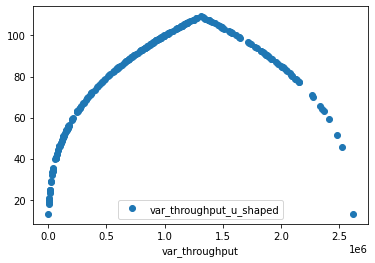

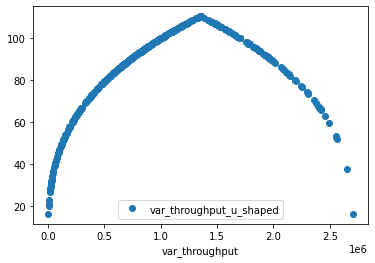

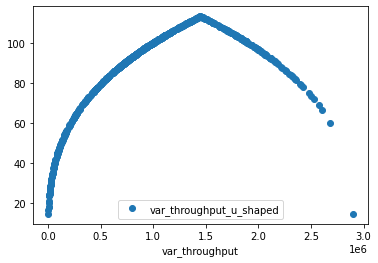

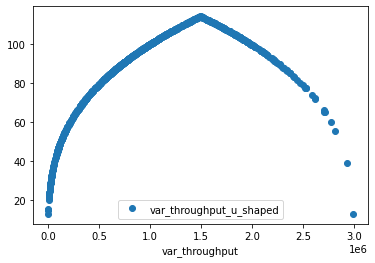

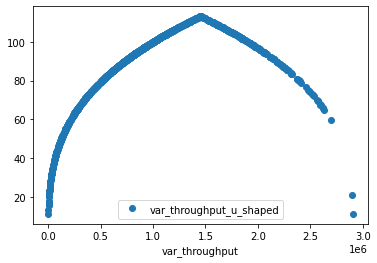

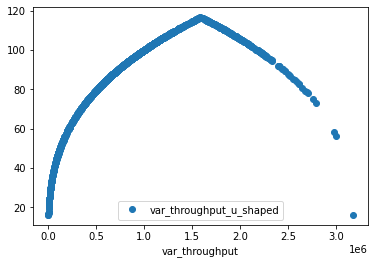

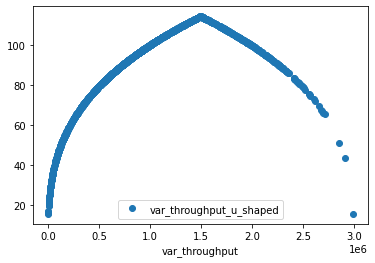

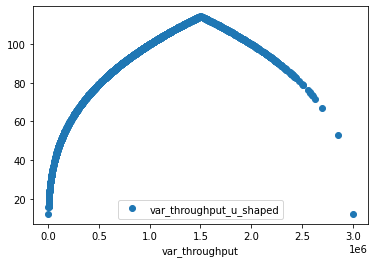

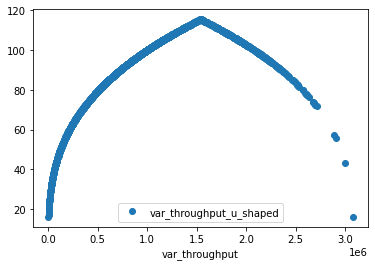

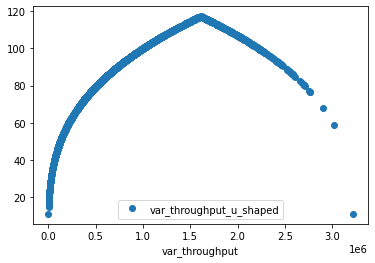

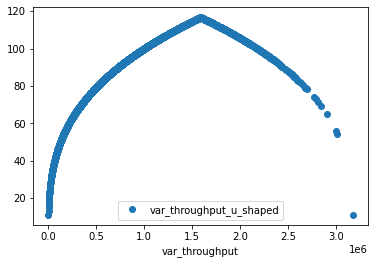

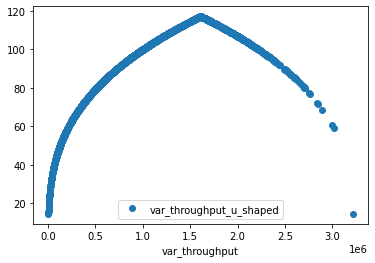

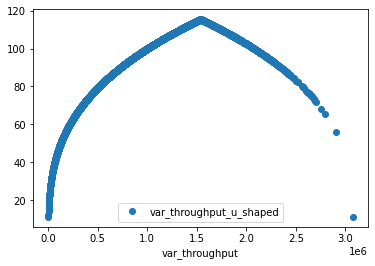

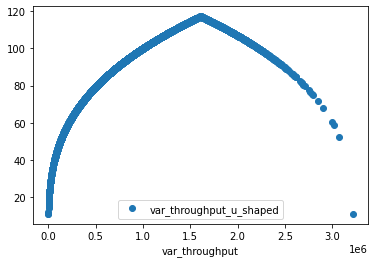

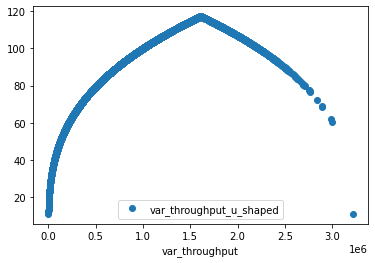

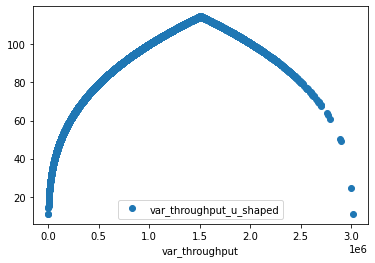

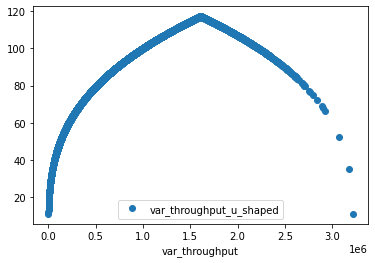

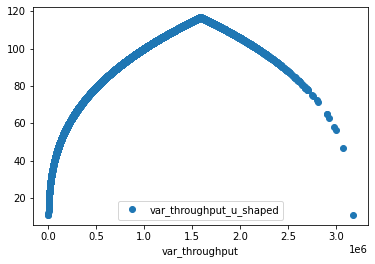

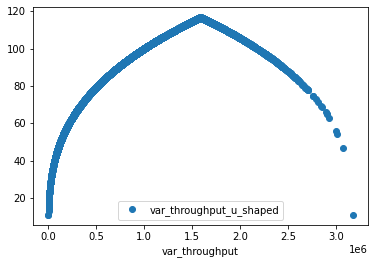

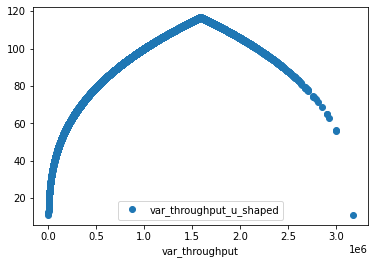

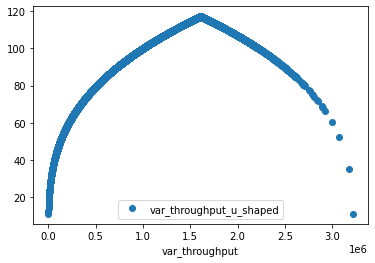

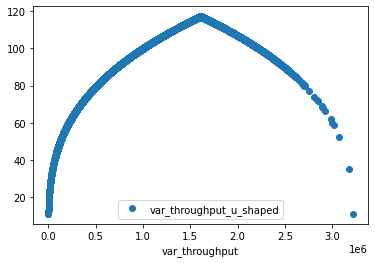

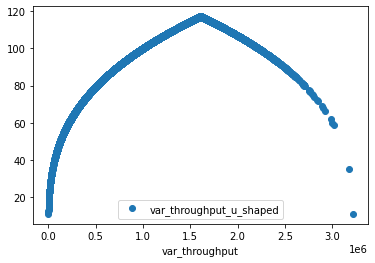

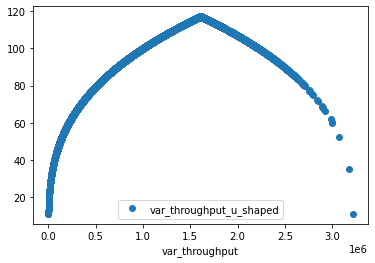

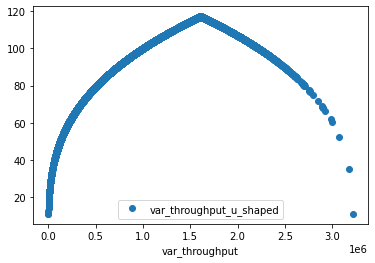

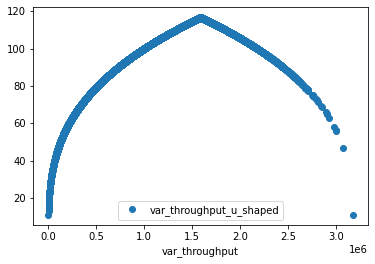

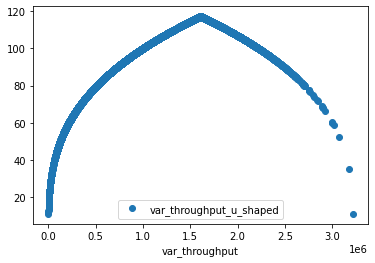

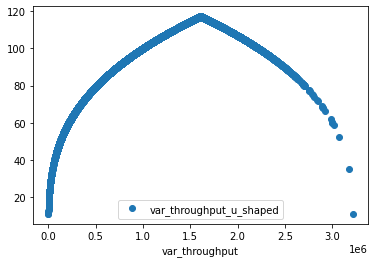

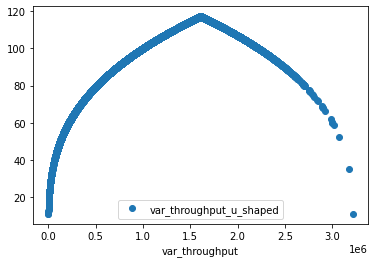

In [9]:
sampling_sizes = [250, 500, 750, 
                  1000, 1250, 1500, 1750, 
                  2000, 2250, 2500, 2750,
                  3000, 3500, 
                  4000, 4500, 
                  5000, 5500, 
                  6000, 6500, 
                  7000, 7500, 
                  8000, 8500, 
                  9000, 9500, 
                  10000, 10500, 11000, 11366]
# sampling_sizes = [11366]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="Input.deception_quadrant", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name,
                                is_drop_rapport=True)

In [10]:
def translate_into_pandas(results_dictionary, metric_of_focus):
    def helper(metric_of_focus_number):
        new_dict = {}
        for each_key, each_values_list in results_dictionary.items():
            new_dict[each_key[4:]] = []
            for each in each_values_list:
                new_dict[each_key[4:]].append(each[metric_of_focus_number])
        out_df = pd.DataFrame.from_dict(new_dict)
        return out_df
    
    if metric_of_focus == 'F1':
        metric_of_focus_number = 0
    elif metric_of_focus == 'Precision':
        metric_of_focus_number = 1
    elif metric_of_focus == 'Recall':
        metric_of_focus_number = 2
        
    return helper(metric_of_focus_number)

metric_of_focus = ['F1', 'Precision', 'Recall']

for metric in metric_of_focus:
    experiment_df = translate_into_pandas(results_dict, metric)
    results_name = "./output/dataset_sampling_" + str(len(sampling_sizes)) + '_' + str(metric) + "_pts_last_new"
    experiment_df.to_csv(results_name + ".csv", index=False)

In [11]:
experiment_df.head()

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,1.000000,0.736391,0.233676,0.365591,0.537985,0.325432,0.584259,0.249214,...,0.375115,0.045261,0.459931,0.660238,0.674693,0.00000,0.969849,0.599785,0.303723,0.000000
1,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
2,0.0,0.0,0.984848,0.834173,0.331527,0.367573,0.210551,0.380695,0.578015,0.605251,...,0.208698,0.360141,0.465281,0.287634,0.735812,0.21643,0.326807,0.364661,0.788535,0.417779
3,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
4,0.0,0.0,1.000000,1.000000,0.252803,0.965093,0.975619,0.029483,1.000000,0.803038,...,1.000000,1.000000,0.000000,0.950997,0.968196,1.00000,0.076635,0.901220,0.139404,0.062354


In [12]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

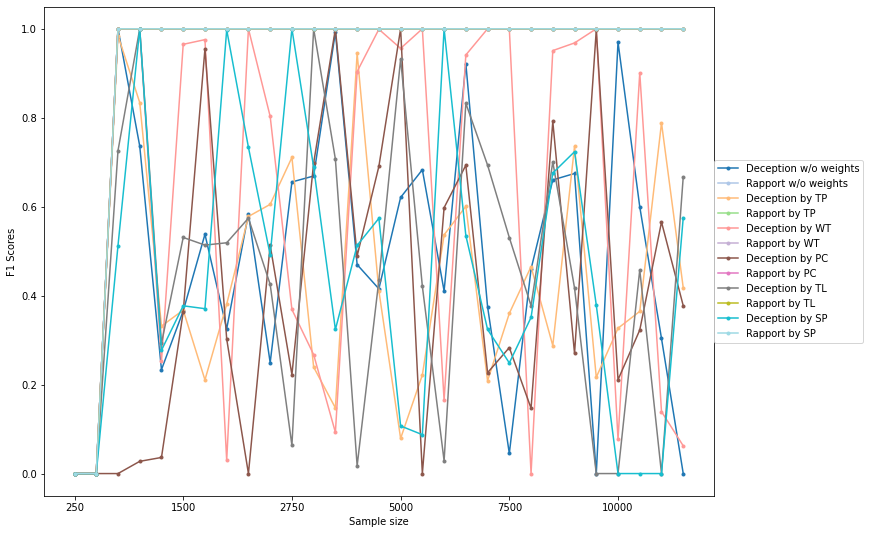

In [13]:
plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
plot.set_xlabel('Sample size', size=10)
plot.set_ylabel('F1 Scores', size=10)
lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
plot = plot.get_figure()
plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [25]:
experiment_df = pd.read_csv("/home/kaiyuan/Desktop/ky_code/affcon/diplomacy-betrayal/output/dataset_sampling_29_F1_pts_last_new.csv")

predict_option = "deception"

if predict_option == "rapport":
    row_names = [0,2,4,6,8,10]
else:
    row_names = [1,3,5,7,9,11]

experiment_df = experiment_df.drop(row_names)
experiment_df

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,0.997375,0.845333,0.378794,0.529635,0.695347,0.481882,0.720126,0.394965,...,0.538251,0.085006,0.620374,0.783603,0.791671,0.000000,0.960270,0.736898,0.458828,0.000000
2,0.0,0.0,0.989623,0.903731,0.495168,0.533040,0.341251,0.543169,0.715849,0.742306,...,0.340258,0.522973,0.625662,0.440697,0.835432,0.350783,0.483044,0.525603,0.860174,0.577620
4,0.0,0.0,0.997375,0.996032,0.400355,0.973476,0.980919,0.056442,0.990047,0.877168,...,0.984996,0.982160,0.000000,0.957894,0.966250,0.975185,0.140042,0.924183,0.241008,0.115133
6,0.0,0.0,0.000000,0.052500,0.069594,0.529109,0.970275,0.459865,0.000000,0.666734,...,0.366784,0.433956,0.254160,0.869464,0.418284,0.974080,0.341657,0.480075,0.709406,0.537513
8,0.0,0.0,0.838267,0.996032,0.450066,0.683616,0.672309,0.675408,0.713007,0.588981,...,0.807670,0.683933,0.540101,0.809084,0.579350,0.000000,0.000000,0.613563,0.000000,0.782794
10,0.0,0.0,0.674649,0.996032,0.432143,0.543163,0.534978,0.988626,0.833466,0.650808,...,0.483438,0.390801,0.511694,0.794870,0.825185,0.540830,0.000000,0.000000,0.000000,0.715611


In [26]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

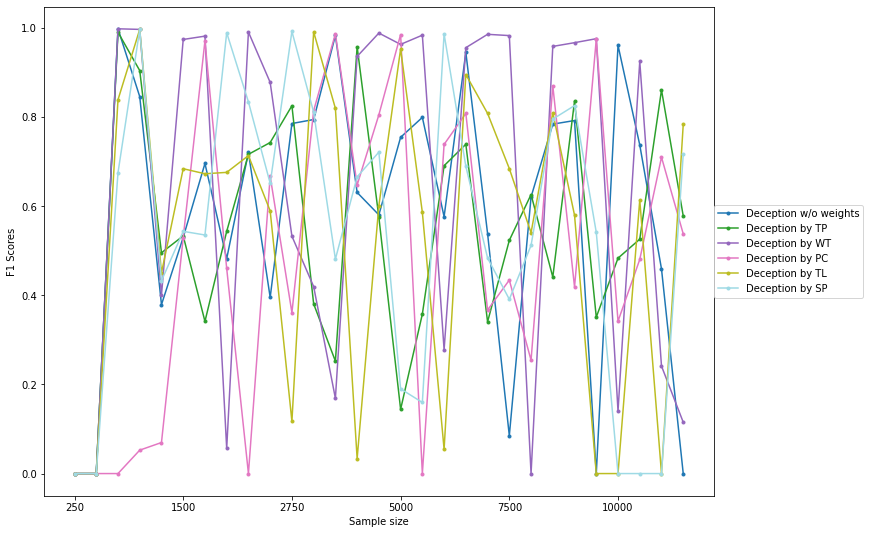

In [27]:
plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
plot.set_xlabel('Sample size', size=10)
plot.set_ylabel('F1 Scores', size=10)
lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
plot = plot.get_figure()
plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
results_dict

{'run_250': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 'run_500': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 'run_750': [[0.9973753094673157, 0.9947916865348816, 1.0],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.9896233677864075, 0.9947916865348816, 0.9848484992980957],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.0, 0.0, 0.0],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.8382667899131775, 0.9931972622871399, 0.7260326743125916],
  [0.9973753094673157, 0.9947916865348816, 1.0],
  [0.67464941740036